# Finetuning with MNLI

After finding our best model, follow this notebook to finetune the model with MNLI dataset

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import pickle as pkl
import datetime
import random
import numpy as np
import torch
import os
import copy
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

import load_data
# from models import *
from training import *

In [2]:
HIDDEN_DIM = 100
MAX_SENTENCE_LENGTH = 30
BATCH_SIZE = 32
NUM_CLASS = 3
LEARNING_RATE = 0.0005
NUM_EPOCHES = 10

DATA_PATH = 'data/'

In [3]:
class LRClassifier(nn.Module):
    def __init__(self, n_in, n_out):
        """
        n_in: Number of features
        n_out: Number of output classes
        """
        super().__init__()
        
        # Set up out linear layer. This initializes the weights
        self.linear = nn.Linear(n_in, n_out)
        
        # Explicitly initialize the weights with the initialization
        self.init_weights()
    
    def forward(self, x):
        """
        x: Input data [N, k]
        ---
        Returns: log probabilities of each class [N, c]
        """
        # Apply the linear function to get our logit (real numbers)
        logit = self.linear(x)
        
        # Apply log_softmax to get logs of normalized probabilities
        return F.log_softmax(logit, dim=1)
    
    def init_weights(self):
        # Use some specific initialization schemes
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

class NNClassifier(nn.Module):
    def __init__(self, n_in, h_s, n_out):
        super().__init__()
        self.linear1 = nn.Linear(n_in,h_s)
        self.linear2 = nn.Linear(h_s,h_s)
        self.linear3 = nn.Linear(h_s,n_out)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return F.log_softmax(x)
        

class BOWEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, class_in):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BOWEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,class_in)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        out = self.linear(out.float())
        return out

class NNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_in, h_s, n_out, combine_mode):
        super().__init__()
        self.encoder = BOWEncoder(vocab_size, embed_dim, n_in)
        self.combine_mode = combine_mode
        if self.combine_mode == 'DIRECT':
            n_in = n_in * 2;
        self.classifier = NNClassifier(n_in,h_s, n_out)
    
    def forward(self, premise, len_premise, hypothesis, len_hypo):
        premise = self.encoder(premise, len_premise)
        hypothesis = self.encoder(hypothesis, len_hypo)
        if self.combine_mode == 'DIRECT':
            x = torch.cat((premise, hypothesis),1)
        elif self.combine_mode == 'MUL':
            x = torch.mul(premise, hypothesis)
        elif self.combine_mode == 'SUB':
            x = torch.sub(premise, hypothesis)
        x = self.classifier(x)
        return x
    
class LRModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_in, n_out, combine_mode):
        super().__init__()
        self.encoder = BOWEncoder(vocab_size, embed_dim, n_in)
        self.combine_mode = combine_mode
        if self.combine_mode == 'DIRECT':
            n_in = n_in * 2;
        self.classifier = LRClassifier(n_in, n_out)
    
    def forward(self, premise, len_premise, hypothesis, len_hypo):
        premise = self.encoder(premise, len_premise)
        hypothesis = self.encoder(hypothesis, len_hypo)
        if self.combine_mode == 'DIRECT':
            x = torch.cat((premise, hypothesis),1)
        elif self.combine_mode == 'MUL':
            x = torch.mul(premise, hypothesis)
        elif self.combine_mode == 'SUB':
            x = torch.sub(premise, hypothesis)
        x = self.classifier(x)
        return x

### Initialize MNLI data

In [4]:
mnli_train = pd.read_csv(DATA_PATH + "mnli_train.tsv", sep='\t')
mnli_val = pd.read_csv(DATA_PATH + "mnli_val.tsv", sep='\t')

mnli_train_data = load_data.prepare_data(mnli_train)
mnli_val_data = load_data.prepare_data(mnli_val)

print ("Train dataset size is {}".format(len(mnli_train_data)))
print ("Val dataset size is {}".format(len(mnli_val_data)))

Train dataset size is 20000
Val dataset size is 5000


In [5]:
all_genre = mnli_train_data.genre.unique().tolist()
all_genre

['telephone', 'fiction', 'slate', 'government', 'travel']

## Initialize and load our best model (both NN and LR)
#### LR

In [6]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 50
CAT_MODE = 'MUL'

id2token_lr = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id_lr = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))
    
BEST_LR_MODEL = 'models/snli/log-reg_best.pt'
num_embed = len(id2token_lr)
# embed_layer = nn.Embedding(num_embed, embed_dim)
lr_best_model = LRModel(VOCAB_SIZE, EMBEDDING_DIM, len(id2token_lr), NUM_CLASS, CAT_MODE)
lr_best_model.load_state_dict(torch.load(BEST_LR_MODEL, map_location=torch.device('cpu')))

criterion = nn.NLLLoss()
optimizer_lr = optim.Adam(lr_best_model.parameters(), lr = LEARNING_RATE)

#### NN

In [7]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 500
CAT_MODE = 'MUL'

id2token_nn = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id_nn = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))
    
BEST_NN_MODEL = 'models/snli/neural-net_best.pt'
num_embed = len(id2token_nn)
embed_dim = EMBEDDING_DIM
embed_layer = nn.Embedding(num_embed, embed_dim)
nn_best_model = NNModel(VOCAB_SIZE, EMBEDDING_DIM, len(id2token_nn) , HIDDEN_DIM, NUM_CLASS, CAT_MODE)
nn_best_model.load_state_dict(torch.load(BEST_NN_MODEL, map_location=torch.device('cpu')))

criterion = nn.NLLLoss()
optimizer_nn = optim.Adam(nn_best_model.parameters(), lr = LEARNING_RATE)

# 3.2 Evaluating on MultiNLI

In [8]:
def get_data_loaders(genre, token2id):
    mnli_train_tel = mnli_train_data[mnli_train_data['genre'] == genre]
    mnli_val_tel = mnli_val_data[mnli_val_data['genre'] == genre]
    indiced_train_data, train_target = load_data.token2index_dataset(mnli_train_tel, token2id)
    indiced_val_data, val_target = load_data.token2index_dataset(mnli_val_tel, token2id)

    train_dataset = load_data.SNLIDataset(indiced_train_data, train_target)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=load_data.SNLI_collate_func,
                                               shuffle=True)

    val_dataset = load_data.SNLIDataset(indiced_val_data, val_target)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=load_data.SNLI_collate_func,
                                               shuffle=True)

    return train_loader, val_loader

In [9]:
model_type = {'lr': (lr_best_model, token2id_lr), 'nn': (nn_best_model, token2id_nn)}
df_eval = pd.DataFrame(index=model_type.keys(), columns=all_genre)
for name, (model, token2id) in model_type.items():
    for genre in all_genre:
        _, val_loader = get_data_loaders(genre, token2id)
        val_acc = acc(val_loader, model)
        df_eval[genre][name] = val_acc

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


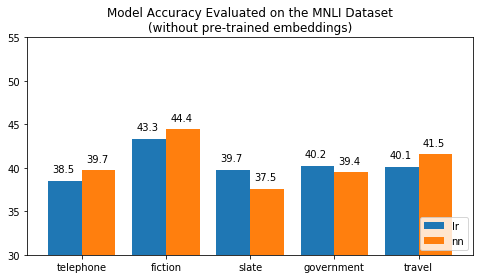

In [10]:
ax = df_eval.T.plot(kind='bar', title='Model Accuracy Evaluated on the MNLI Dataset\n(without pre-trained embeddings)', 
               figsize=(8, 4), width=0.8, ylim=(30,55), rot=0)
ax.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], xy=(p.get_x()+0.05, p.get_height()+1))
plt.savefig('evalMNLI.png')

In [11]:
df_eval

,telephone,fiction,slate,government,travel
lr,38.5075,43.3166,39.7206,40.2559,40.1222
nn,39.7015,44.4221,37.525,39.4685,41.5479


# 3.3 Fine-tuning on MultiNLI
pick the best model over either NN or LR

In [12]:
SAVE_FOLDER = os.path.join('models', 'mnli')
if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

In [13]:
# for genre in all_genre:
#     print('*'*30, genre, '*'*30)
#     best_model = copy.deepcopy(nn_best_model)
#     optimizer = optimizer_nn
#     token2id = token2id_nn
#     criterion = nn.NLLLoss()
#     optimizer = optim.Adam(best_model.parameters(), lr = LEARNING_RATE)
#     train_loader, val_loader = get_data_loaders(genre, token2id)
#     train_model(best_model, train_loader, val_loader, 
#                      optimizer, criterion, n_epochs=10, save_file=SAVE_FOLDER+'/'+genre+'_model.pt')

In [14]:
telephone_model = NNModel(VOCAB_SIZE, EMBEDDING_DIM, len(id2token_nn) , HIDDEN_DIM, NUM_CLASS, CAT_MODE)
telephone_model.load_state_dict(torch.load(SAVE_FOLDER+'/telephone_model.pt'))

fiction_model = NNModel(VOCAB_SIZE, EMBEDDING_DIM, len(id2token_nn) , HIDDEN_DIM, NUM_CLASS, CAT_MODE)
fiction_model.load_state_dict(torch.load(SAVE_FOLDER+'/fiction_model.pt'))

slate_model = NNModel(VOCAB_SIZE, EMBEDDING_DIM, len(id2token_nn) , HIDDEN_DIM, NUM_CLASS, CAT_MODE)
slate_model.load_state_dict(torch.load(SAVE_FOLDER+'/slate_model.pt'))

government_model = NNModel(VOCAB_SIZE, EMBEDDING_DIM, len(id2token_nn) , HIDDEN_DIM, NUM_CLASS, CAT_MODE)
government_model.load_state_dict(torch.load(SAVE_FOLDER+'/government_model.pt'))

travel_model = NNModel(VOCAB_SIZE, EMBEDDING_DIM, len(id2token_nn) , HIDDEN_DIM, NUM_CLASS, CAT_MODE)
travel_model.load_state_dict(torch.load(SAVE_FOLDER+'/travel_model.pt'))

In [15]:
finetuned_models = {'telephone_model': telephone_model, 
                    'fiction_model': fiction_model, 
                    'slate_model': slate_model, 
                    'government_model': government_model, 
                    'travel_model': travel_model}

In [16]:
df = pd.DataFrame(index=finetuned_models, columns=all_genre)
for model_type, model in finetuned_models.items():
    for genre in all_genre:
        _, val_loader = get_data_loaders(genre, token2id)
        val_acc = acc(val_loader, model)
        df[genre][model_type] = val_acc

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [17]:
df

,telephone,fiction,slate,government,travel
telephone_model,48.5572,45.3266,41.7166,44.8819,44.8065
fiction_model,43.5821,45.6281,40.3194,42.0276,43.7882
slate_model,44.1791,43.1156,44.3114,44.685,47.1487
government_model,46.4677,46.3317,43.6128,50,49.1853
travel_model,46.8657,45.7286,43.513,49.9016,50.611


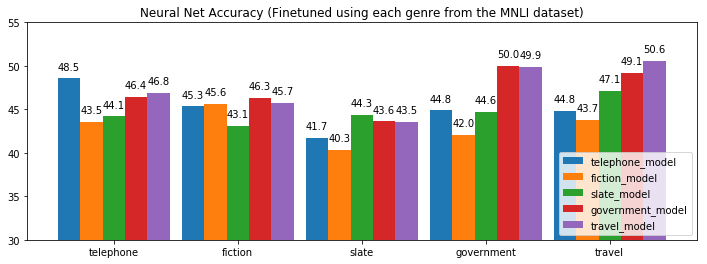

In [18]:
ax = df.T.plot(kind='bar', title='Neural Net Accuracy (Finetuned using each genre from the MNLI dataset)', 
             figsize=(12, 4), width=0.9, ylim=(30,55), rot=0)
ax.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], xy=(p.get_x(), p.get_height()+1))
plt.savefig('tunedMNLI_all.png')

The finetuned models are uploaded to [this gdrive folder](https://drive.google.com/drive/folders/1TRwEd7O2ifC72eBJBJ1-zTBfG0nUC1tF?usp=sharing).

In [19]:
df_individual = pd.DataFrame([df['telephone']['telephone_model'], 
                              df['fiction']['fiction_model'], 
                              df['slate']['slate_model'], 
                              df['government']['government_model'], 
                              df['travel']['travel_model']], index=all_genre, columns=['nn finetuned'])
df_before_and_after = pd.concat([df_eval,df_individual.T])

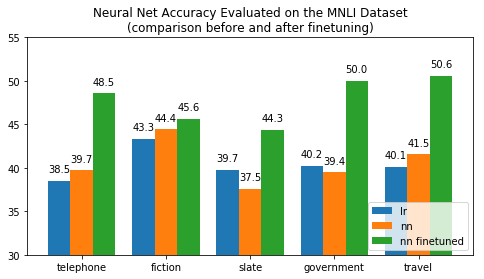

In [20]:
ax = df_before_and_after.T.plot(kind='bar', title='Neural Net Accuracy Evaluated on the MNLI Dataset\n(comparison before and after finetuning)', 
             figsize=(8, 4), width=0.8, ylim=(30,55), rot=0)
ax.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], xy=(p.get_x(), p.get_height()+1))
plt.savefig('tunedMNLI.png')

In [21]:
df_before_and_after

,telephone,fiction,slate,government,travel
lr,38.5075,43.3166,39.7206,40.2559,40.1222
nn,39.7015,44.4221,37.525,39.4685,41.5479
nn finetuned,48.5572,45.6281,44.3114,50,50.611


# 3.4 Pre-trained Model Evaluating on MultiNLI

In [26]:
class LRClassifier(nn.Module):
    def __init__(self, n_in, n_out):
        """
        n_in: Number of features
        n_out: Number of output classes
        """
        super().__init__()
        # Set up out linear layer. This initializes the weights
        self.linear = nn.Linear(n_in, n_out)
        # Explicitly initialize the weights with the initialization
        self.init_weights()
    def forward(self, x):
        """
        x: Input data [N, k]
        ---
        Returns: log probabilities of each class [N, c]
        """
        # Apply the linear function to get our logit (real numbers)
        logit = self.linear(x)
        # Apply log_softmax to get logs of normalized probabilities
        return F.log_softmax(logit, dim=1)
    def init_weights(self):
        # Use some specific initialization schemes
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.uniform_(self.linear.bias)

class NNClassifier(nn.Module):
    def __init__(self, n_in, h_s, n_out):
        super().__init__()
        self.linear1 = nn.Linear(n_in,h_s)
        self.linear2 = nn.Linear(h_s,h_s)
        self.linear3 = nn.Linear(h_s,n_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return F.log_softmax(x)

class BOWEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, class_in, is_pretrained):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BOWEncoder, self).__init__()
        if is_pretrained:
            weights_matrix = self.create_weights(vectors, id2token)
            self.embed  = self.create_emb_layer(weights_matrix, is_pretrained)
        else:
            self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,class_in)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        out = self.linear(out.float())
        return out
    
    def create_weights(self, vectors, id2token):
        '''Create weights metrics from vectors and id2token
        Returns:
        weights_matrix: torch.Tensor, dimension of (vocab size x embedding dim)
        '''
        weights_matrix = torch.from_numpy(np.array([vectors[id2token[i]] for i in range(2, len(id2token))]))
        zero = torch.zeros(2, weights_matrix.size()[1], dtype=torch.float64)
        weights_matrix = torch.cat([zero, weights_matrix])
        return weights_matrix

    
    def create_emb_layer(self, weights_matrix, non_trainable=False):
        '''Create embedding layer that's used in a PyTorch model
        Returns:
        emb_layer: nn.Embedding()
        num_embeddings: int
        embedding_dim: int
        '''
        num_embeddings, embedding_dim = weights_matrix.size()
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        if non_trainable:
            emb_layer.weight.requires_grad = False
        return emb_layer

class NNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_in, h_s, n_out, combine_mode, is_pretrained):
        super().__init__()
        self.encoder = BOWEncoder(vocab_size, embed_dim, n_in, is_pretrained)
        self.combine_mode = combine_mode
        if combine_mode == 'DIRECT':
            n_in = n_in * 2;
        self.classifier = NNClassifier(n_in,h_s, n_out)
    
    def forward(self, premise, len_premise, hypothesis, len_hypo):
        premise = self.encoder(premise, len_premise)
        hypothesis = self.encoder(hypothesis, len_hypo)
        if self.combine_mode == 'DIRECT':
            x = torch.cat((premise, hypothesis),1)
        elif self.combine_mode == 'MUL':
            x = torch.mul(premise, hypothesis)
        elif self.combine_mode == 'SUB':
            x = torch.sub(premise, hypothesis)
        x = self.classifier(x)
        return x
    
class LRModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_in, n_out, combine_mode, is_pretrained):
        super().__init__()
        self.encoder = BOWEncoder(vocab_size, embed_dim, n_in, is_pretrained)
        self.combine_mode = combine_mode
        if combine_mode == 'DIRECT':
            n_in = n_in * 2;
        self.classifier = LRClassifier(n_in, n_out)
    
    def forward(self, premise, len_premise, hypothesis, len_hypo):
        premise = self.encoder(premise, len_premise)
        hypothesis = self.encoder(hypothesis, len_hypo)
        if self.combine_mode == 'DIRECT':
            x = torch.cat((premise, hypothesis),1)
        elif self.combine_mode == 'MUL':
            x = torch.mul(premise, hypothesis)
        elif cself.ombine_mode == 'SUB':
            x = torch.sub(premise, hypothesis)
        x = self.classifier(x)
        return x

#### LR

In [27]:
VOCAB_SIZE = 100000
CAT_MODE = 'DIRECT'

vectors = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_vectors.pkl', 'rb'))
id2token = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))
    
LR_PRETRAINED_MODEL = 'models/snli/pretrain_log-reg_best.pt'
lr_pretrained_model = LRModel(VOCAB_SIZE, 300, len(id2token), 3, CAT_MODE, is_pretrained = True)
lr_pretrained_model.load_state_dict(torch.load(LR_PRETRAINED_MODEL, map_location=torch.device('cpu')))

#### NN

In [28]:
VOCAB_SIZE = 100000
CAT_MODE = 'DIRECT'

vectors = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_vectors.pkl', 'rb'))
id2token = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_id2token.pkl', 'rb'))
token2id = pkl.load(open('pickle/'+str(VOCAB_SIZE)+'_token2id.pkl', 'rb'))
    
NN_PRETRAINED_MODEL = 'models/snli/pretrain_neural-net_best.pt'
num_embed = len(id2token)
nn_pretrained_model = NNModel(VOCAB_SIZE, 300, num_embed, HIDDEN_DIM, 3, CAT_MODE, is_pretrained = True)
nn_pretrained_model.load_state_dict(torch.load(NN_PRETRAINED_MODEL, map_location=torch.device('cpu')))

In [29]:
model_type = {'lr_pretrained': (lr_pretrained_model, token2id), 'nn_pretrained': (nn_pretrained_model, token2id)}
df_eval_pretrained = pd.DataFrame(index=model_type.keys(), columns=all_genre)
for name, (model, token2id) in model_type.items():
    for genre in all_genre:
        _, val_loader = get_data_loaders(genre, token2id)
        val_acc = acc(val_loader, model)
        df_eval_pretrained[genre][name] = val_acc

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


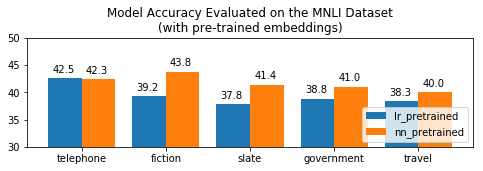

In [30]:
ax = df_eval_pretrained.T.plot(kind='bar', title='Model Accuracy Evaluated on the MNLI Dataset\n(with pre-trained embeddings)', 
               figsize=(8, 2), width=0.8, ylim=(30,50), rot=0)
ax.legend(loc='lower right')
for p in ax.patches:
    ax.annotate(str(p.get_height())[:4], xy=(p.get_x()+0.05, p.get_height()+1))
plt.savefig('evalMNLI_pretrained.png')

In [31]:
df_eval_pretrained

,telephone,fiction,slate,government,travel
lr_pretrained,42.5871,39.2965,37.8244,38.878,38.391
nn_pretrained,42.3881,43.8191,41.4172,41.0433,40.0204
